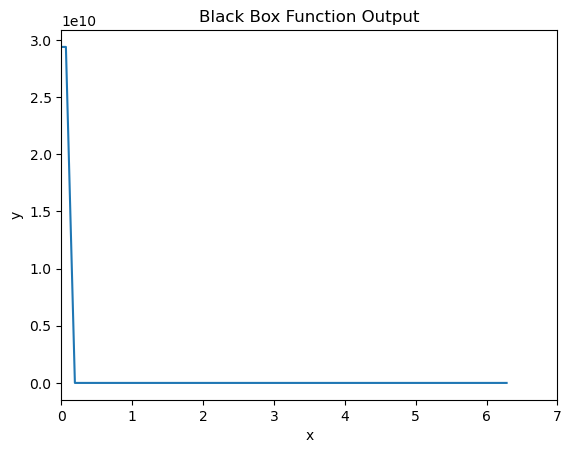

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def black_box_function(r, eps, sigma):
    y = 4*eps*((sigma/r)**12-(sigma/r)**6)
    return y

# range of x values
x_range = np.linspace(-2*np.pi, 2*np.pi, 100)
eps = 0.27
sigma = 0.47

# output for each x value
black_box_output = black_box_function(x_range, eps, sigma)

# plot
plt.plot(x_range, black_box_output)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,7)
plt.title('Black Box Function Output')
plt.show()

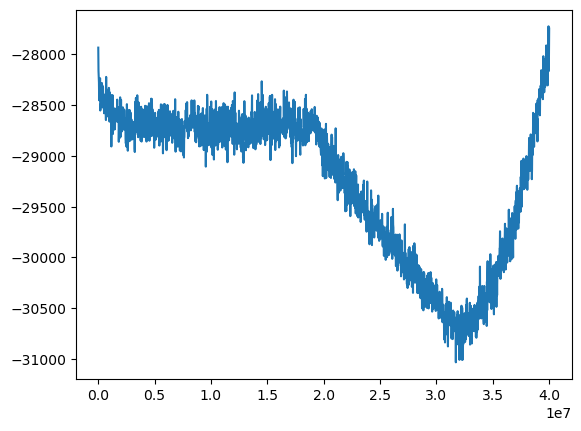

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import lammps_logfile
np.random.seed(42)

log = lammps_logfile.File("../test_scripts/Ben_BO_data/SMD_6_4_cvel_0.000001_log.lammps")
y = log.get("TotEng")
x = log.get("Step")
plt.plot(x, y)
plt.show()

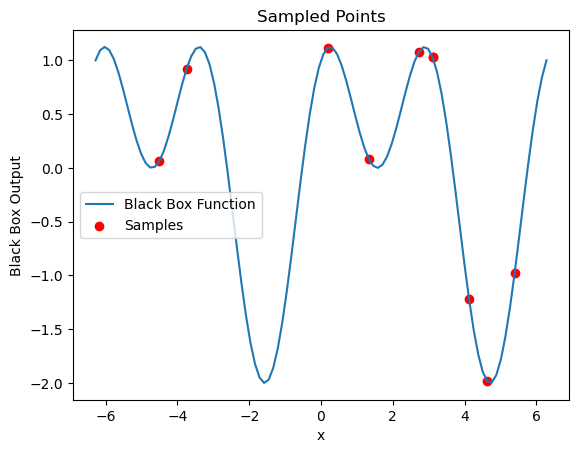

In [2]:
# random x values for sampling
num_samples = 10
sample_x = np.random.choice(x_range, size=num_samples)

# output for each sampled x value
sample_y = black_box_function(sample_x)

# plot
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.show()

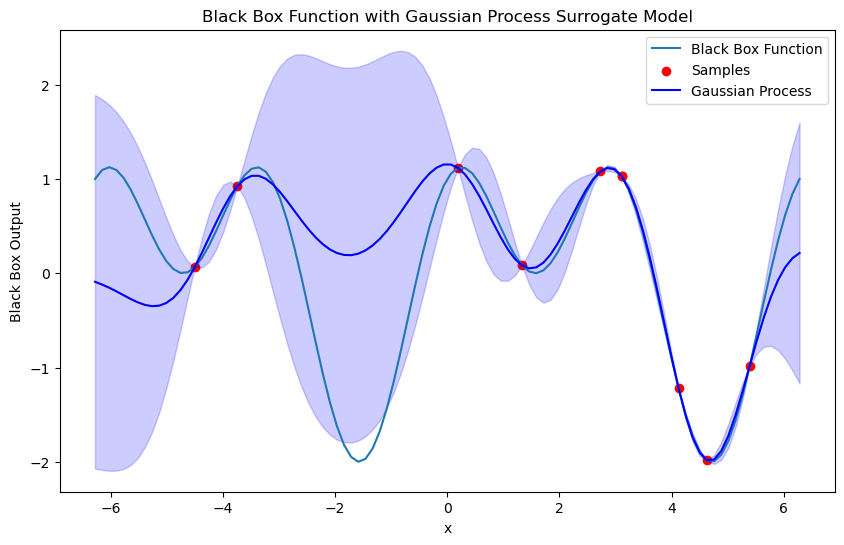

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Gaussian process regressor with an RBF kernel
kernel = RBF(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel)

# Fit the Gaussian process model to the sampled points
gp_model.fit(sample_x.reshape(-1, 1), sample_y)

# Generate predictions using the Gaussian process model
y_pred, y_std = gp_model.predict(x_range.reshape(-1, 1), return_std=True)

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(x_range, black_box_function(x_range), label='Black Box Function')
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.plot(x_range, y_pred, color='blue', label='Gaussian Process')
plt.fill_between(x_range, y_pred - 2*y_std, y_pred + 2*y_std, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Black Box Function with Gaussian Process Surrogate Model')
plt.legend()
plt.show()

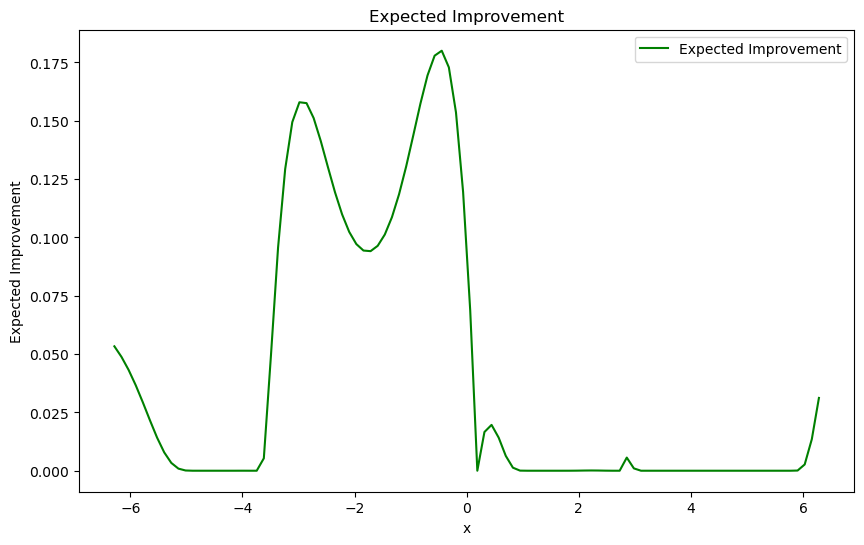

In [4]:
from scipy.stats import norm

def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determine the point with the highest observed function value
best_idx = np.argmax(sample_y)
best_x = sample_x[best_idx]
best_y = sample_y[best_idx]

ei = expected_improvement(x_range, gp_model, best_y)

# Plot the expected improvement
plt.figure(figsize=(10, 6))
plt.plot(x_range, ei, color='green', label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('Expected Improvement')
plt.title('Expected Improvement')
plt.legend()
plt.show()

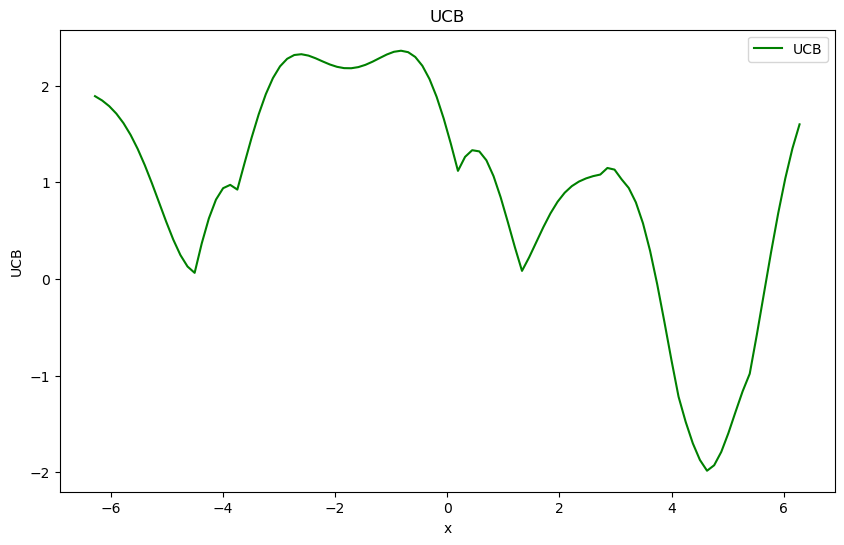

In [5]:
def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    ucb = y_pred + beta * y_std
    return ucb

beta = 2.0

# UCB
ucb = upper_confidence_bound(x_range, gp_model, beta)

plt.figure(figsize=(10, 6))
plt.plot(x_range, ucb, color='green', label='UCB')
plt.xlabel('x')
plt.ylabel('UCB')
plt.title('UCB')
plt.legend()
plt.show()

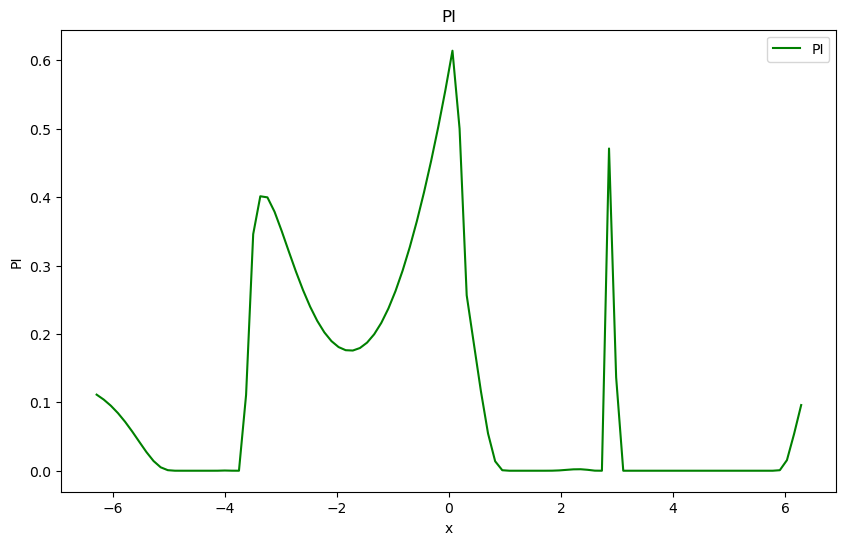

In [6]:
def probability_of_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

# Probability of Improvement
pi = probability_of_improvement(x_range, gp_model, best_y)


plt.figure(figsize=(10, 6))
plt.plot(x_range, pi, color='green', label='PI')
plt.xlabel('x')
plt.ylabel('PI')
plt.title('PI')
plt.legend()
plt.show()

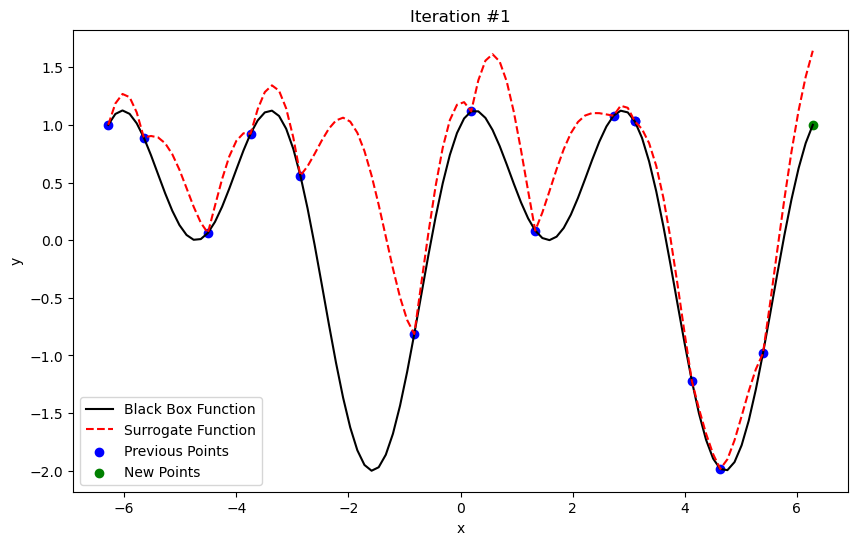

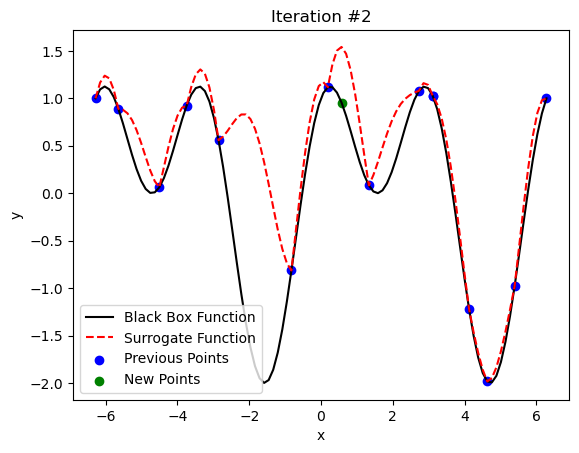

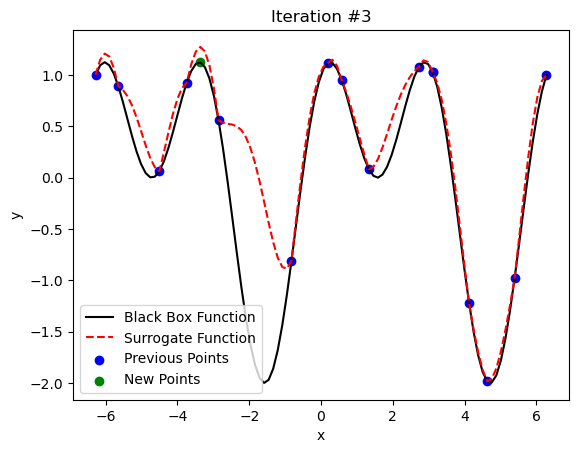

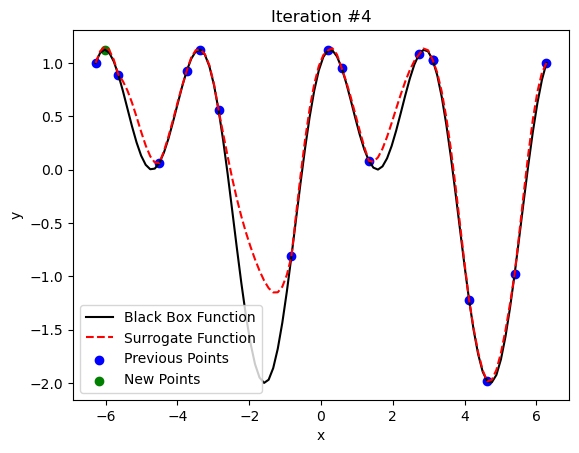

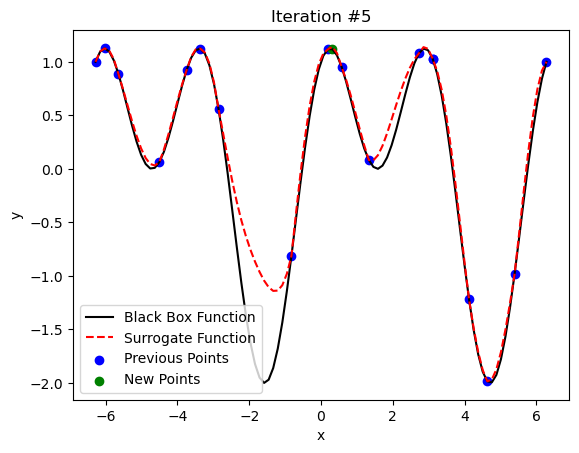

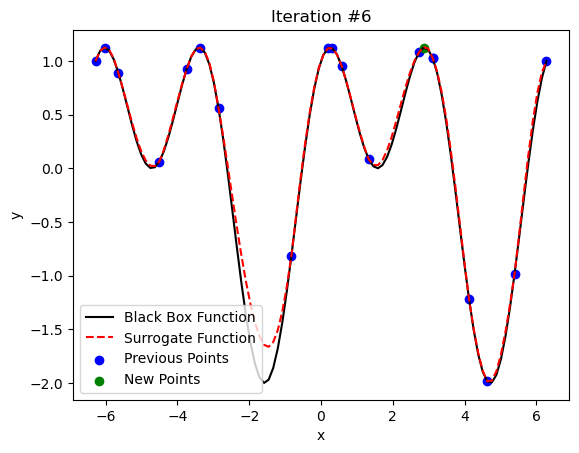

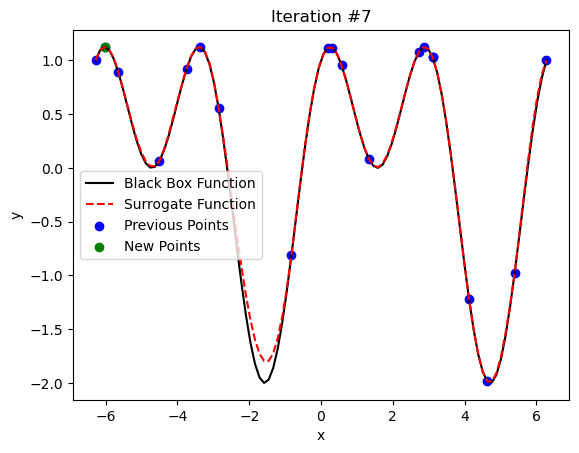

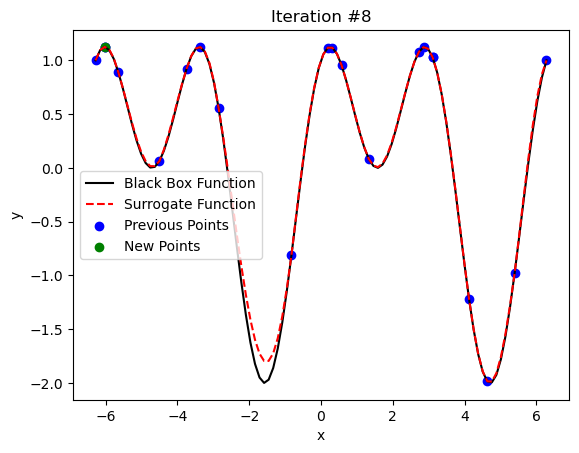

/Users/blaubach/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


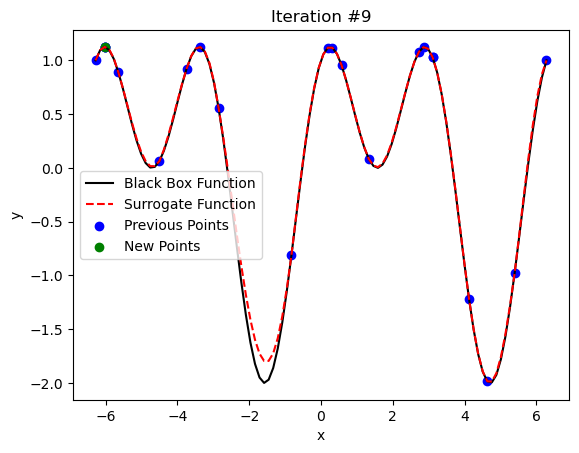

/Users/blaubach/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


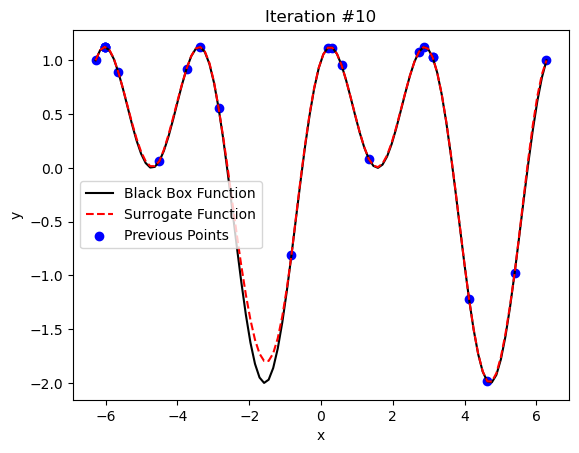

In [8]:
num_iterations = 10

plt.figure(figsize=(10, 6))

for i in range(num_iterations):
    # Fit the Gaussian process model to the sampled points
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)

    # Determine the point with the highest observed function value
    best_idx = np.argmax(sample_y)
    best_x = sample_x[best_idx]
    best_y = sample_y[best_idx]

    # Set the value of beta for the UCB acquisition function
    beta = 2.0

    # Generate the Upper Confidence Bound (UCB) using the Gaussian process model
    ucb = upper_confidence_bound(x_range, gp_model, beta)

    # Plot the black box function, surrogate function, previous points, and new points
    plt.plot(x_range, black_box_function(x_range), color='black', label='Black Box Function')
    plt.plot(x_range, ucb, color='red', linestyle='dashed', label='Surrogate Function')
    plt.scatter(sample_x, sample_y, color='blue', label='Previous Points')
    if i < num_iterations - 1:
        new_x = x_range[np.argmax(ucb)]  # Select the next point based on UCB
        new_y = black_box_function(new_x)
        sample_x = np.append(sample_x, new_x)
        sample_y = np.append(sample_y, new_y)
        plt.scatter(new_x, new_y, color='green', label='New Points')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend()
    plt.show()